# Introduction to Jupyter Notebooks on Google Colab
## A tool for metabolomics data science

This is the first of two notebooks. It will first illustrate core LC-MS concepts, spectra and mass tracks. Next, we will focus on common QC tasks for exploring raw metabolomics data prior to processing, including plotting total ion chromatograms (TICs), base peak chromatograms (BPCs), boxplots of summed scan intensities, heatmaps of sample similarity, and extracted ion chromatograms (EICs) of known metabolites in our data (e.g. spike-ins). These visualizations help us assess the quality of the collected data and identify outliers or low-quality samples that may need to be removed prior to downstream statistical analysis.

## Notebook setup

This notebook is designed to run in Google Colab, which comes pre-installed with several core Python libraries such as NumPy, pandas, matplotlib, and seaborn - so minimal setup is needed to get started. In the code box below, we will install the **asari-metabolomics** library, which bundles classic metabolomics tools including **pymzml** and **mass2chem**.

Note the exclamation mark at the beginning of the **pip** command - it tells the Jupyter notebook to run the line as a shell command.

In [1]:
# 1 - setup

!pip3 install asari-metabolomics

import pymzml
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import numpy as np
import seaborn as sns
import requests, zipfile, io

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.1/273.1 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.1 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26098 sha256=e15d8413d142ff1c9606b3a33ac5b5873b7250db7ddc17b0c9cc5906fd2ade23
  Stored in directory: /root/.cache/pip/wheels/31/d7/d9/eec6891f78cac19a693bd40ecb8365d2f4613318c145ec9816
Successfully built intervaltree


## Data download

Next, we'll download the raw **.mzML** files from our GitHub repository to begin exploring data quality through simple summary statistics and visualizations.

The dataset we are using consists of plasma samples analyzed using HILIC positive ion mode (HILIC-Pos) and includes:

- **Qstds (Quality standard samples):** Used to assess instrument performance and consistency over time.
- **A blank sample:** Used to identify background noise and contamination.
- **A DDA sample:** Collected for MS/MS fragmentation for metabolite identification.

In [2]:
# 2 - download raw data

# GitHub API URL of mzMLs
api_url = "https://api.github.com/repos/shuzhao-li-lab/2025_DataScience/contents/data"
download_dir = "./Datasets"

os.makedirs(download_dir, exist_ok=True)

# get file list in the folder
response = requests.get(api_url)
if response.status_code != 200:
    raise Exception(f"Failed to fetch contents: {response.status_code}")

files = response.json()

# loop through and download each file
for file_info in files:
    if file_info["type"] == "file":
        download_url = file_info["download_url"]
        filename = file_info["name"]
        print(f"Downloading {filename}...")

        file_response = requests.get(download_url)
        with open(os.path.join(download_dir, filename), "wb") as f:
            f.write(file_response.content)

In [3]:
# 3 - put all mzML files in a list

file_list = glob.glob("./Datasets/*.mzML")
print(len(file_list))

11


In [4]:
# 4 - look at the metadata to understand the dataset

meta = pd.read_csv('./Datasets/hilic_pos_metadata.csv')
meta['Sample'] = meta['file_name'].astype(str) + '.mzML'
meta = meta.drop(['path', 'process_method', 'position', 'new_name', 'instrument_method'], axis=1)
display(meta)

,sample_type,file_name,sample_id,batch,comment,inj_vol,Sample
0,QC,MT_20210726_001,Qstd_20210726_1_001,1,1,2,MT_20210726_001.mzML
1,QC,MT_20210726_003,Qstd_20210726_1_003,1,1,2,MT_20210726_003.mzML
2,QC,MT_20210726_005,Qstd_20210726_1_005,1,1,2,MT_20210726_005.mzML
3,QC,MT_20210726_007,Qstd_20210726_1_007,2,1,2,MT_20210726_007.mzML
4,QC,MT_20210726_009,Qstd_20210726_1_009,2,1,2,MT_20210726_009.mzML
5,QC,MT_20210726_010,Qstd_20210726_1_010,2,1,2,MT_20210726_010.mzML
6,QC,MT_20210726_013,Qstd_20210726_1_013,3,1,2,MT_20210726_013.mzML
7,QC,MT_20210726_015,Qstd_20210726_1_015,3,1,2,MT_20210726_015.mzML
8,QC,MT_20210726_019,Qstd_20210726_1_019,3,1,2,MT_20210726_019.mzML
9,QC,MT_20210726_011,Qstd_DDA_20210726_1_001,1,1,2,MT_20210726_011.mzML


### Reading and visualizing spectra

The goal of metabolomics is to comprehensively profile all small molecules present in a given sample. This is achieved using a mass spectrometer coupled to a liquid chromatographer (LC), which separates and measures the abundance of ionized molecules.

The most fundamental unit in mass spectrometry is the **mass spectrum**, which is a plot of the mass-to-charge ratio (m/z, X-axis) versus ion intensity (Y-axis). In this plot, each peak represents a detected ion, with its height corresponding to its relative abundance. Spectra are essential to identify metabolites by matching observed peaks to expected m/z values. Through the course of a LC-MS run, the instrument collects a series of scans at successive retention times (like snapshots), each producing a mass spectrum of m/z vs intensity pairs.  

Now that we have clarified some core concepts and downloaded the .mzML files, let's read in a single sample and visualize a spectrum.



In [10]:
# 5 - use the first sample in the file list
infile = file_list[0]

# read in the .mzML
sample0 = pymzml.run.Reader(infile)

# load all spectra into memory and save it in the spectra object
# which is a Python list, each element an individual spectrum
spectra = [x for x in sample0]

len(spectra)

786

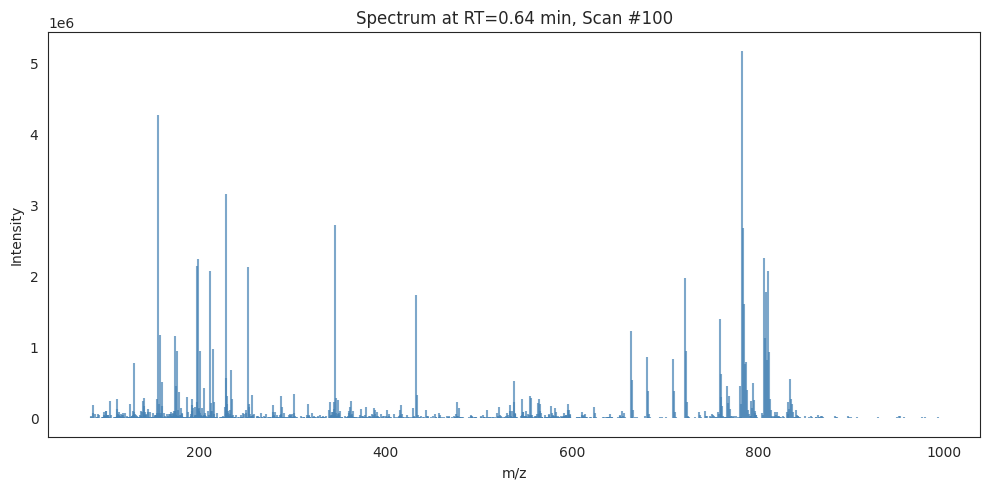

In [17]:
# 6 - visualizing a spectrum
# let's use scan 100
# remember Python indexing starts at 0

scan_number = 100-1

# access the 100th spectrum
spectrum = spectra[scan_number]

# extract (m/z, intensity) pairs
mz, intensity = zip(*spectrum.peaks("centroided"))

# setup plot background and size
sns.set_style("white")
plt.figure(figsize=(10, 5))

# plot each peak as a vertical line
plt.vlines(mz, [0], intensity, color="steelblue", alpha=0.7)

# add labels and title
plt.xlabel("m/z")
plt.ylabel("Intensity")
plt.title(f"Spectrum at RT={spectrum.scan_time[0]:.2f} min, Scan #{spectrum.ID}")

# adjust the layout so everything fits nicely in the plot
plt.tight_layout()
plt.show()

In spectrum 100, we see two regions with a high density of peaks, concentrated at 100 and 200 m/z respectively.

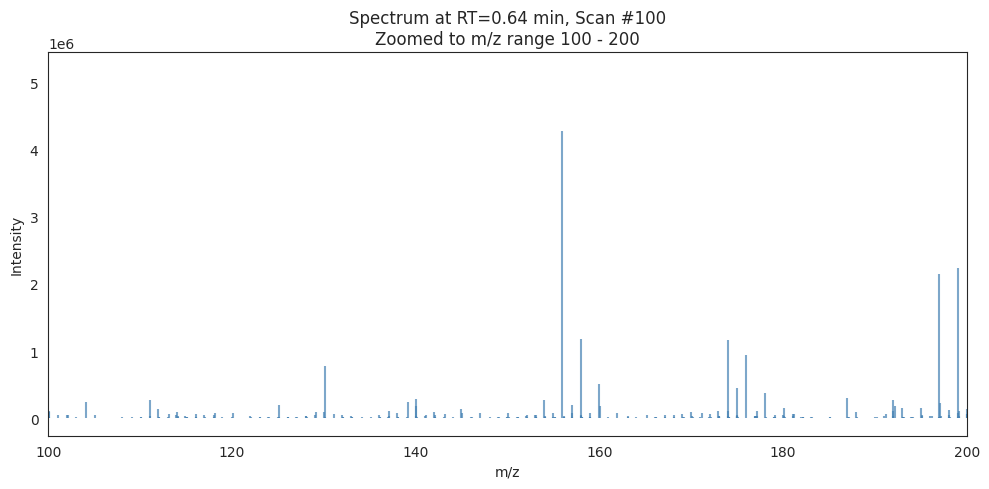

In [24]:
# 7 - zoom in
# sometimes we want to focus on a region of interest
# in this case, many common small polar plasma metabolties
# fall within the 100-200 mz range
# eg creatinine = 114, carnitine = 162

mz_min, mz_max = 100, 200

# setup plot background and size
sns.set_style("white")
plt.figure(figsize=(10, 5))

# plot each peak as a vertical line
plt.vlines(mz, [0], intensity, color="steelblue", alpha=0.7)

# add labels and title
plt.xlabel("m/z")
plt.ylabel("Intensity")
plt.title(f"Spectrum at RT={spectrum.scan_time[0]:.2f} min, Scan #{spectrum.ID}\n"
f"Zoomed to m/z range {mz_min} - {mz_max}")

# set x-axis limits
plt.xlim(mz_min, mz_max)

# adjust the layout so everything fits nicely in the plot
plt.tight_layout()
plt.show()

In [26]:
# 8 - get peak with highest intensity
# we see the highest peak intensity near 155 m/z
# but let's get the actual m/z value

# convert to numpy array
mz_arr = np.array(mz)
intensity_arr = np.array(intensity)

# subset to only peaks within the range
# makes array of True/False values
mask = (mz_arr >= mz_min) & (mz_arr <= mz_max)

# apply the mask
filtered_mz = mz_arr[mask]
filtered_intensity = intensity_arr[mask]

# get index of max intensity
max_idx = np.argmax(filtered_intensity)

# get corresponding m/z and intensity
peak_mz = filtered_mz[max_idx]
peak_intensity = filtered_intensity[max_idx]

print(f"Peak m/z: {peak_mz:.4f}, intensity: {peak_intensity}")


Peak m/z: 155.9746, intensity: 4273386.0


### Understanding mass tracks

Another important concept in metabolomics data processing - originally introduced by Li et al. in Asari, is the **mass track**. A mass track is defined as an extracted chromatogram for a specific m/z value, capturing how that ion's intensity changes across the entire retention time in a single sample. This is similar to an EIC, which reflects the elution profile of compounds with a specific m/z as they elute through the chromatographic column.

Mass tracks form the fundamental building blocks of Asari's data model. For an in-depth explanation to Asari and how to use the pipeline, please refer to Chapter X in the companion book, where the workflow is covered in great detail.

For this tutorial, we will focus on exploring the structure of a mass track and visualizing it.

In [29]:
# 9 - extract mass tracks
from asari import chromatograms as ch

mass_tracks = ch.extract_massTracks_(sample0)

# list all the keys in mass_tracks (dictionary)
print("Mass track keys:")
print(mass_tracks.keys())


Mass track keys:
dict_keys(['rt_numbers', 'rt_times', 'tracks'])


The mass track contains three keys:

* rt_numbers = scan number
* rt_times = retention times for each scan number
* tracks = the tracks; list of EICs for all detected m/z values

Let's also check what the tracks looks like.

In [42]:
# 10 - mass tracks structure
# how many EICs are there
print("Number of tracks:")
print(len(mass_tracks['tracks']))

# let's look what a track is made of
# note it is made of two elements
# 1 - a float (np.float64) - m/z value for this track
# 2 - an array - intensity values across retention time
print("Components of a track:")
mass_tracks['tracks'][100] # selecting track 100

Number of tracks:
7646
Components of a track:


(np.float64(97.03985214233398),
 array([ 30876,  35696,      0,  16043,  27701,  22521,  30307,  16868,
             0,  25966,  12742,  18831,  14299,  16970,  11370,   6757,
         13475,   8841,  10733,   8727,   7637,      0,      0,   9301,
         16231,  13343,  12981,  11091,  12010,      0,   8755,   5354,
          9615,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,  16795,      0,  18365,  17904,      0,  32744, 113981,
        166743,  27867,      0,  55680,      0,      0,      0,      0,
         12801,  15947,   9104,  14099,  12039,      0,  10525,      0,
         11230,      0,  19159,      0,  23440,  10680,  13564,  12843,
             0,      0,  12285,   9979,  10739,      0,      0,  10672,
             0,  11074,   8890,      0,  20624,      0,      0,  15640,
             0,  11224,  10648,  12591,   9880,   8901,  21723,   8379,
         12770,      0,  12788, 

In [43]:
# 11 - linking components together
# the intensity array inside each track is the same length as rt_numbers and rt_times
print("Length of rt_numbers:")
print(len(mass_tracks['rt_numbers']))

print("Length of intensity array:")
print(len(mass_tracks['tracks'][100][1]))

# so indexing the intensity array corresponds to the scan and rt times

Length of rt_numbers:
786
Length of intensity array:
786


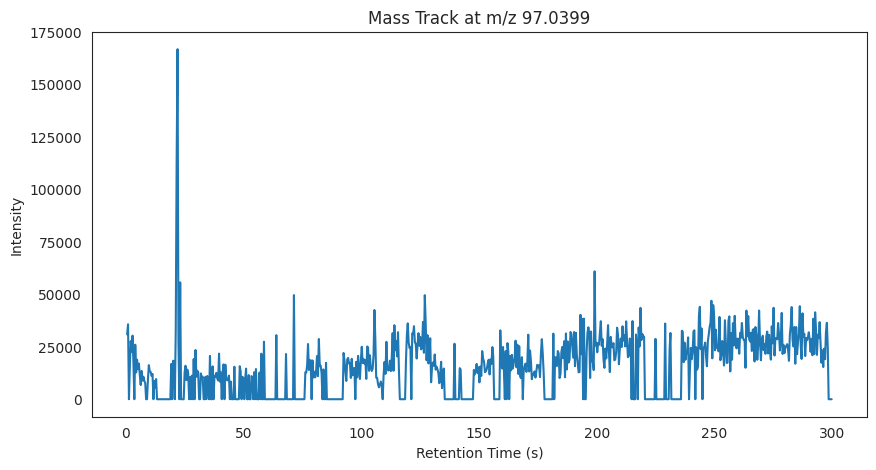

In [46]:
# 12 - visualize track 100
this_mz = mass_tracks['tracks'][100][0]
intensity = mass_tracks['tracks'][100][1]
rt_times = mass_tracks['rt_times']

# setup DataFrame
df = pd.DataFrame({
    'Retention Time': rt_times,
    'Intensity': intensity
})

# set figure size
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='Retention Time', y='Intensity')

plt.title(f"Mass Track at m/z {this_mz:.4f}")
plt.xlabel("Retention Time (s)")
plt.ylabel("Intensity")
plt.show()


### Summary metrics

Now that we have a good understanding of LC-MS concepts, let us move onto QC. A simple first check is to look at the file size. This indicates whether files are corrupt or empty.

In [ ]:
# 13 - file size
from IPython.display import display

data = []
for f in file_list:
    try:
        size_bytes = os.path.getsize(f)
        size_mb = size_bytes / (1024 * 1024)  # convert to MB
        data.append({
            'File Name': os.path.basename(f),
            'Size (MB)': f"{size_mb:.2f}"
        })
    except FileNotFoundError:
        data.append({
            'File Name': os.path.basename(f),
            'Size (MB)': 'File not found'
        })

df_sizes = pd.DataFrame(data).sort_values(by='File Name')
display(df_sizes)

,File Name,Size (MB)
1,Blank_20210726_003.mzML,11.42
5,MT_20210726_001.mzML,9.82
10,MT_20210726_003.mzML,9.82
2,MT_20210726_005.mzML,9.91
0,MT_20210726_007.mzML,10.01
6,MT_20210726_009.mzML,10.04
8,MT_20210726_010.mzML,16.93
9,MT_20210726_011.mzML,18.06
7,MT_20210726_013.mzML,10.14
4,MT_20210726_015.mzML,9.94


All the files seem to fall within 10-20 MB, nothing alarming yet. Next, we will look at the retention time range (start and end time for a compound to elute from the LC column in minutes) of all samples. This checks that acquistion time windows are consistent.

,Sample,RT_min,RT_max,RT_range
5,Blank_20210726_003.mzML,0.008650,4.998629,4.989979
8,MT_20210726_001.mzML,0.006466,4.999850,4.993384
7,MT_20210726_003.mzML,0.008618,4.996449,4.987832
2,MT_20210726_005.mzML,0.008655,4.996790,4.988134
3,MT_20210726_007.mzML,0.008648,4.998599,4.989951
0,MT_20210726_009.mzML,0.008588,4.996085,4.987497
1,MT_20210726_010.mzML,0.011466,4.997172,4.985706
4,MT_20210726_011.mzML,0.008665,4.985207,4.976542
6,MT_20210726_013.mzML,0.006473,4.993789,4.987317
9,MT_20210726_015.mzML,0.008605,4.999664,4.991059


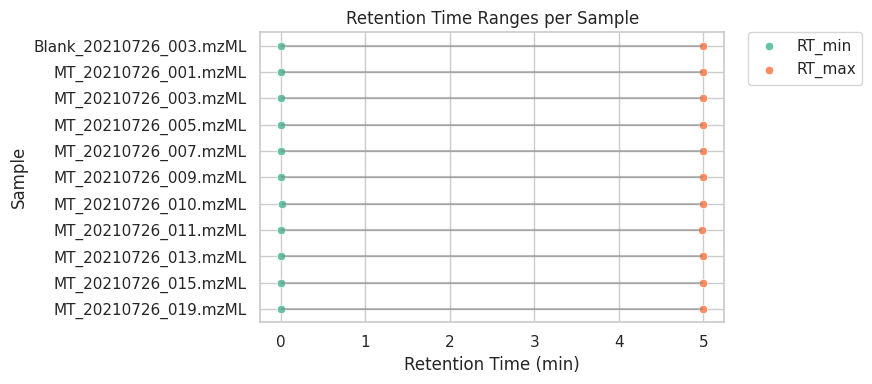

In [ ]:
# 14 - RT range

rt_ranges = []

for file_path in file_list:
    run = pymzml.run.Reader(file_path, build_index_from_scratch=True)
    sample_name = os.path.basename(file_path)

    rt_values = []
    for spectrum in run:
        if spectrum.ms_level == 1:
            try:
                rt = spectrum.scan_time_in_minutes()
            except:
                rt = spectrum.scan_time
            rt_values.append(rt)

    if rt_values:
        rt_min = min(rt_values)
        rt_max = max(rt_values)
        rt_ranges.append({
            'Sample': sample_name,
            'RT_min': rt_min,
            'RT_max': rt_max,
            'RT_range': rt_max - rt_min
        })

df_rt_ranges = pd.DataFrame(rt_ranges).sort_values('Sample')
display(df_rt_ranges)

plt.figure(figsize=(9, 4))

# plot points at RT_min and RT_max
palette = sns.color_palette("Set2", 2)

sns.scatterplot(x='RT_min', y='Sample', data=df_rt_ranges, label='RT_min', color=palette[0])
sns.scatterplot(x='RT_max', y='Sample', data=df_rt_ranges, label='RT_max', color=palette[1])

# draw horizontal lines to show ranges
for idx, row in df_rt_ranges.iterrows():
    plt.hlines(
        y=row['Sample'],
        xmin=row['RT_min'],
        xmax=row['RT_max'],
        color='gray',
        alpha=0.5
    )

plt.xlabel('Retention Time (min)')
plt.ylabel('Sample')
plt.title('Retention Time Ranges per Sample')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

From the plot above, all of the ranges are nearly identical, great news!

### TIC and BPC

In this code chunk, we will first extract the intensities per scan across each file. TICs and BPCs are similar, in that it consists of scan intensities across runtime. However, the metrics differ in how they use these intensities. In a TIC, the intensities are summed across all mass spectral peaks for each scan, whereas for a BPC, the most abundant ion per scan is kept. Both can be used to identify samples with abnormally low or noisy signals.


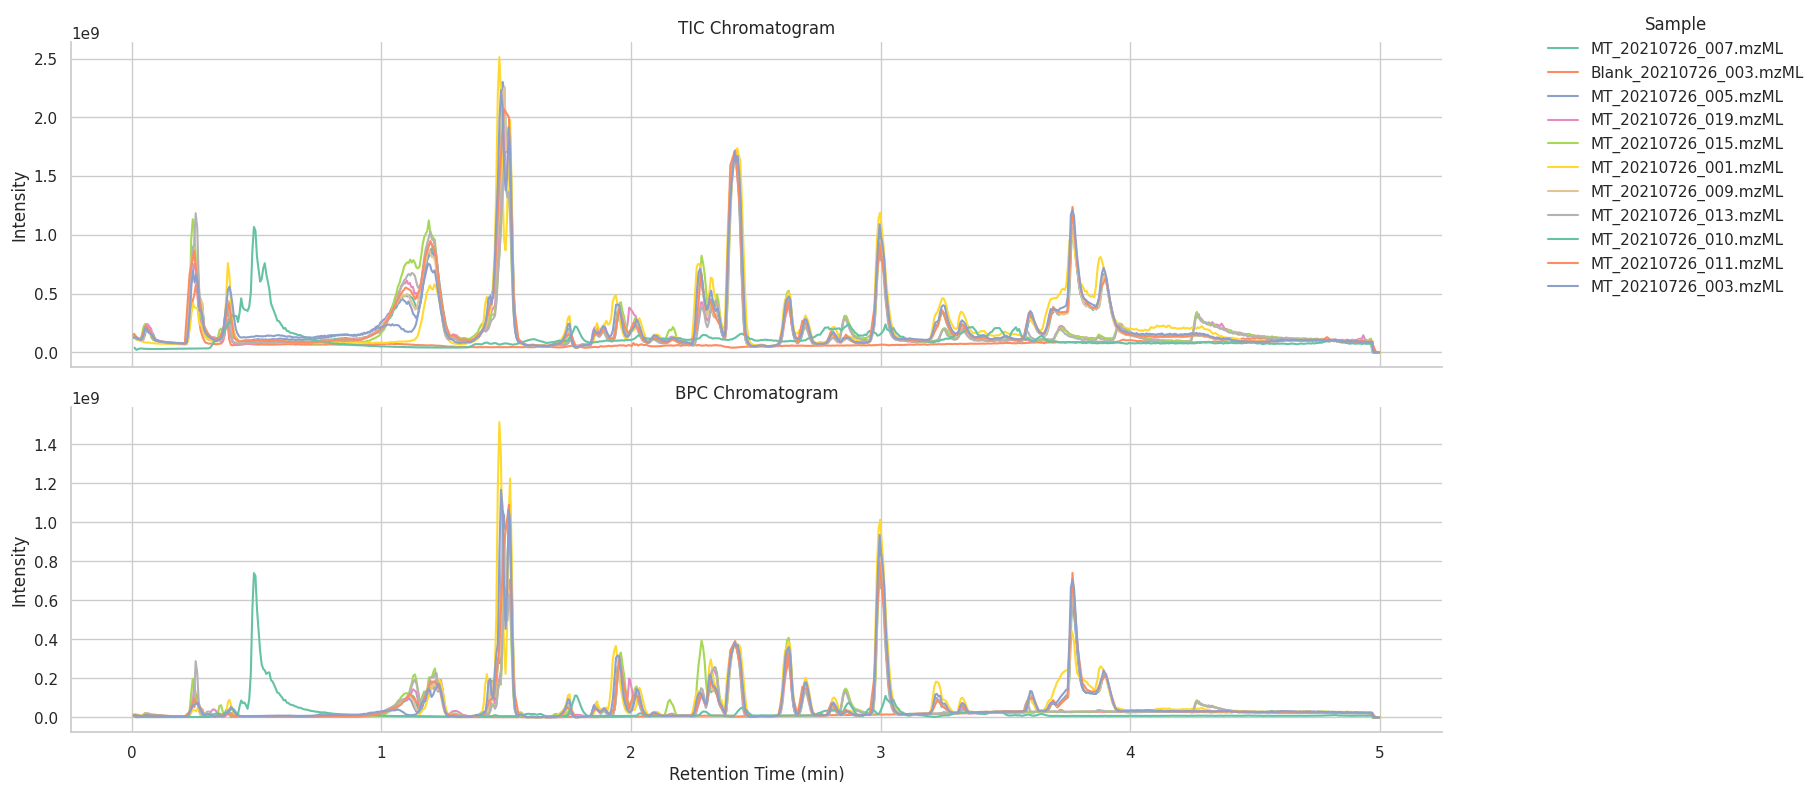

In [ ]:
# 15 - TIC and BPC metrics and plot
data = []

for file_path in file_list:
    run = pymzml.run.Reader(file_path, build_index_from_scratch=True)
    sample_name = os.path.basename(file_path)

    for spectrum in run:
        try:
            ms_level = int(spectrum.ms_level)
        except Exception:
            continue  # skip invalid

        if ms_level == 1:
            try:
                scan_time = spectrum.scan_time_in_minutes()
            except:
                scan_time = spectrum.scan_time  # fallback

            intensities = spectrum.i
            tic = sum(intensities)
            bpc = max(intensities)

            # add both TIC and BPC as separate rows for faceting
            data.append({
                "Sample": sample_name,
                "RetentionTime": scan_time,
                "Intensity": tic,
                "Chromatogram": "TIC"
            })
            data.append({
                "Sample": sample_name,
                "RetentionTime": scan_time,
                "Intensity": bpc,
                "Chromatogram": "BPC"
            })

# create a DataFrame
df = pd.DataFrame(data)

# set seaborn style
sns.set(style="whitegrid")

# create a FacetGrid: one row per chromatogram type
g = sns.FacetGrid(df, row="Chromatogram", height=4, sharex=True, sharey=False, aspect=3)

# map lineplot to each facet
g.map_dataframe(sns.lineplot, x="RetentionTime", y="Intensity", hue="Sample", palette="Set2")

# move legend outside of plot area
g.add_legend(title="Sample", bbox_to_anchor=(1.05, 1), loc='upper left')

# set axis labels and titles
g.set_axis_labels("Retention Time (min)", "Intensity")
g.set_titles("{row_name} Chromatogram")

plt.tight_layout()
plt.show()


### Sample similarity

Next, we will plot a heatmap of the simlarity between samples based on their TIC. This highlights clusters of samples with similar signal profiles, and can reveal batch effects (e.g. are samples from batch 1 and batch 2 clearly different?) and highlight outliers with distinct chromatographic profiles.

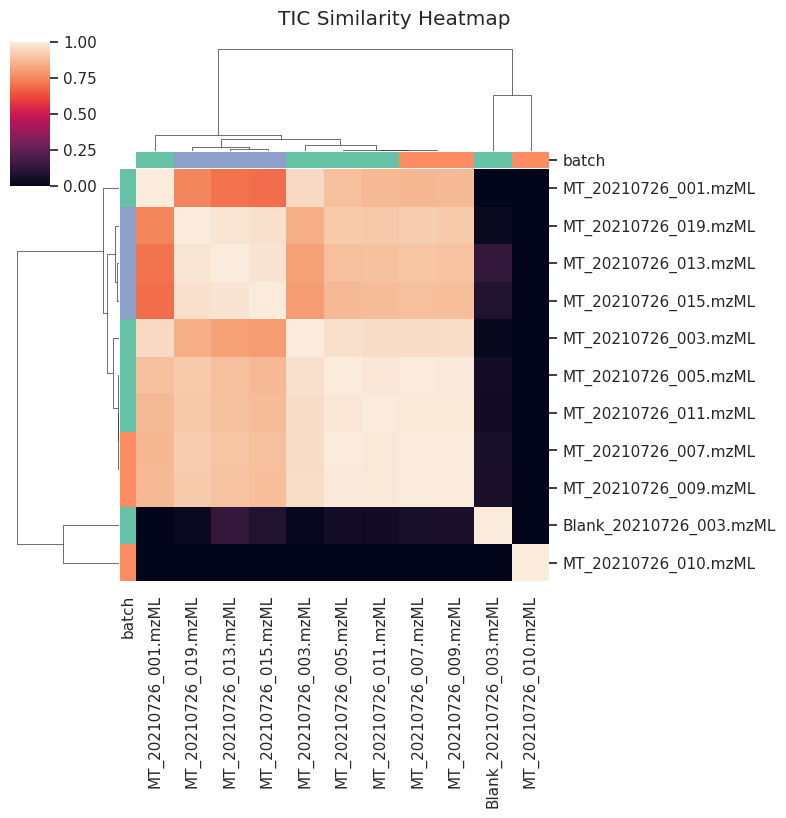

In [ ]:
# 16 - TIC similarity

from scipy.interpolate import interp1d

# use DF from above and filter to only TIC rows
df_tic = df[df['Chromatogram'] == 'TIC'].copy()

# pivot to wide format: index = RT, columns = Sample, values = Intensity
df_pivot = df_tic.pivot(index='RetentionTime', columns='Sample', values='Intensity')

# interpolate each sample to a common retention time grid
rt_common = np.linspace(df_pivot.index.min(), df_pivot.index.max(), 1000)
df_interp = pd.DataFrame(index=rt_common)

for sample in df_pivot.columns:
    # drop NaNs for interpolation
    valid = df_pivot[sample].dropna()
    f = interp1d(valid.index, valid.values, bounds_error=False, fill_value=0)
    df_interp[sample] = f(rt_common)

# compute a Pearson correlation matrix for each sample pair
corr_matrix = df_interp.corr(method='pearson')

# add metadata with sample → batch mapping
meta = meta.set_index('Sample').loc[corr_matrix.index]  # match order

# assign a color to each batch
batch_palette = sns.color_palette("Set2", n_colors=meta['batch'].nunique())
batch_lut = dict(zip(meta['batch'].unique(), batch_palette))
batch_colors = meta['batch'].map(batch_lut)

# plot cluster heatmap with batch color bars
sns.clustermap(
    corr_matrix,
    row_colors=batch_colors,
    col_colors=batch_colors,
    cmap='rocket',
    vmin=0,
    vmax=1,
    figsize=(8, 8)
)

plt.suptitle("TIC Similarity Heatmap",
             y=1.02)
plt.show()

As expected, the blank sample is highly dissimlar to all other samples (does not contain plasma), however it is odd that MT__10 is also dissimilar to all other samples. This is unexpected as it is a Qstd. We should consider removing this file from further downstream analyses.

### Scan count

Next, we will make a barplot of the total number of scans per sample. Inconsistent scan counts may indicate there were acquistion errors.

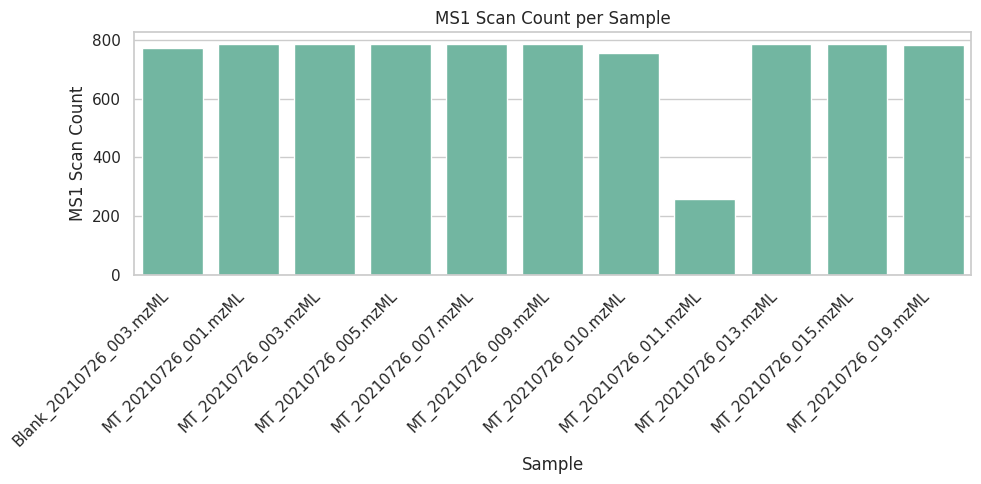

In [ ]:
# 17 - count MS1 scans per file
scan_counts = []

for file_path in file_list:
    run = pymzml.run.Reader(file_path, build_index_from_scratch=True)
    sample_name = os.path.basename(file_path)
    count = sum(1 for spec in run if spec.ms_level == 1)
    scan_counts.append({'Sample': sample_name, 'MS1_ScanCount': count})

# convert to DataFrame
df_scans = pd.DataFrame(scan_counts).sort_values('Sample')

# generate barplot
plt.figure(figsize=(10, 5))
sns.barplot(data=df_scans, x='Sample', y='MS1_ScanCount', color=palette[0])
plt.xticks(rotation=45, ha='right')
plt.ylabel('MS1 Scan Count')
plt.title('MS1 Scan Count per Sample')
plt.tight_layout()
plt.show()

Sample MT__11 has a low MS1 scan count, however this is expected as it is a DDA acquisition.

### Summed ion intensities

In this next section, we will plot a boxplot of summed ion intensities per scan, per file. This can be used to evaluate the overall signal abundance.

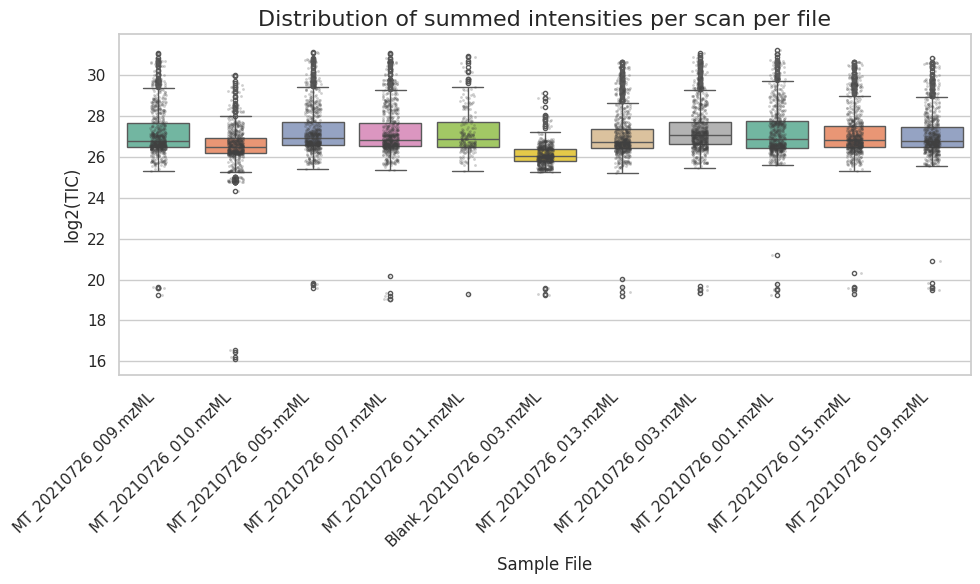

In [ ]:
# 18 - Summed ion intensity
tic_data = []
labels = []

# sum intensities per scan for each file
data = {
    'File': [],
    'log2_TIC': []
}

for file_path in file_list:
    run = pymzml.run.Reader(file_path, build_index_from_scratch=True)
    label = os.path.basename(file_path)

    for spectrum in run:
        if spectrum.ms_level == 1:
            tic = sum(spectrum.i)
            log2_tic = np.log2(tic + 1e-6)
            data['File'].append(label)
            data['log2_TIC'].append(log2_tic)

df = pd.DataFrame(data)

# plot with seaborn
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# add boxplot
ax = sns.boxplot(x='File', y='log2_TIC', data=df, hue = "File",
                 palette="Set2", fliersize=3, legend=False)
# add points (scan)
ax = sns.stripplot(x='File', y='log2_TIC', data=df, color='0.25',
                   size=2, alpha = 0.25, jitter=True)

ax.set_title('Distribution of summed intensities per scan per file', fontsize=16)
ax.set_ylabel('log2(TIC)')
ax.set_xlabel('Sample File')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Overall, the summed intensities across all files are quite consistent, except for the blank and MT_010. We have already identified this sample to be an outlier with above QC metrics, so there are no unexpected surprises here.

### EIC

The final task is to plot EICs, which display the intensity of a specific m/z value over time. This allows us to visualize compound-specific patterns, and confirm the presence of known metabolites in our data, such as spike-in standards. In the code cell below is a function to extract and plot EICs of a target metabolite.

In [ ]:
# 19 - function for EIC
def extract_and_plot_eic(file_list, mz, tolerance=0.01, ms_level=1):
    """
    Extracts and plots EIC (Extracted Ion Chromatograms) for a
    specified m/z across multiple mzML files.

    Parameters:
        file_list (list): List of mzML file paths
        mz (float): Target m/z value
        tolerance (float): ± window around the target m/z, default is 0.01
        ms_level (int): MS level to extract from (default = 1)
    """
    data = []

    for file_path in file_list:
        run = pymzml.run.Reader(file_path, build_index_from_scratch=True)
        sample_name = os.path.basename(file_path)
        rt = []
        intensity = []

        for spectrum in run:
            if spectrum.ms_level == ms_level:
                mz_array = spectrum.mz
                i_array = spectrum.i

                # match peaks within tolerance window
                matched = [i for m, i in zip(mz_array, i_array) if abs(m - mz) <= tolerance]

                if matched:
                    try:
                        scan_time = spectrum.scan_time_in_minutes()
                    except:
                        scan_time = spectrum.scan_time

                    rt.append(scan_time)
                    intensity.append(sum(matched))

        # sort by retention time
        if rt:
            rt, intensity = zip(*sorted(zip(rt, intensity)))
            for t, inten in zip(rt, intensity):
                data.append({
                    "Sample": sample_name,
                    "RetentionTime": t,
                    "Intensity": inten
                })

    # create a DataFrame
    df = pd.DataFrame(data)

    # plot with seaborn
    if not df.empty:
        plt.figure(figsize=(12, 5))
        sns.lineplot(data=df, x="RetentionTime", y="Intensity", hue="Sample", marker=None, palette="Set2")

        plt.xlabel("Retention Time (min)")
        plt.ylabel(f"Intensity at m/z {mz:.2f} ± {tolerance}")
        plt.title(f"Extracted Ion Chromatograms (EIC) at m/z {mz:.2f}")
        plt.legend(title="Sample", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', title_fontsize='small')
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No matching peaks found for m/z {mz} ± {tolerance}.")



This is a list of known compounds and their molecular weight in our samples, which we will use to plot EICs.
*   [¹³C₃]-Caffeine - spike-in - 197.0905
*   L-Valine - common plasma metabolite -	117.0789
*   L-Phenylalanine	- common plasma metabolite -	165.0790

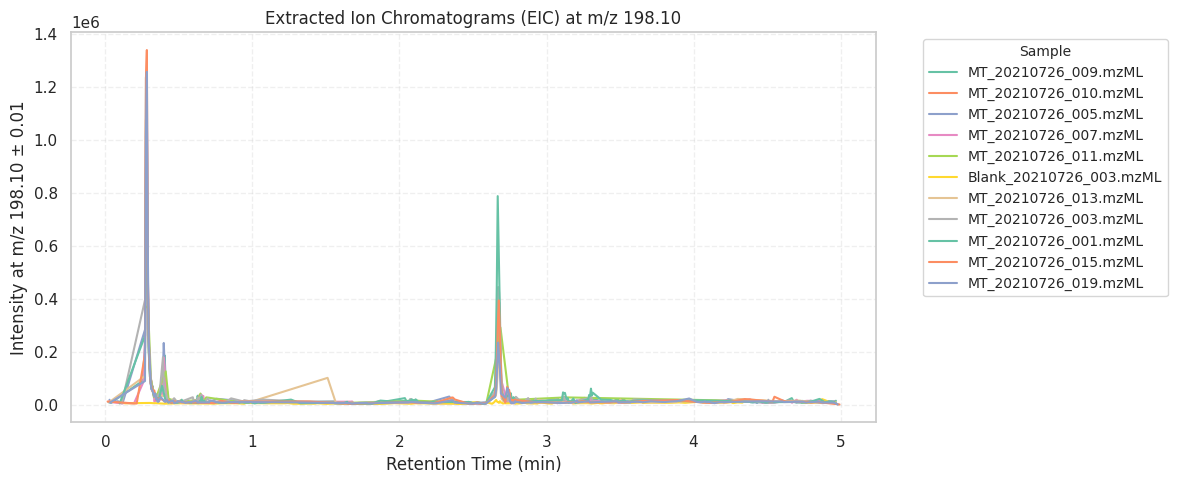

In [ ]:
# 20 - [¹³C₃]-Caffeine + [M+H]+
mol_weight = 197.0905 + 1.007276
extract_and_plot_eic(file_list, mz = mol_weight, tolerance = 0.01)

# while we do see two peaks, the first peak is likely an artifact (too early, in the void volumn).
# Also the peak shape is noisy. The second peak is cleaner (low background noise,
# good Gaussian shape) and is well-retained (RT common across samples).

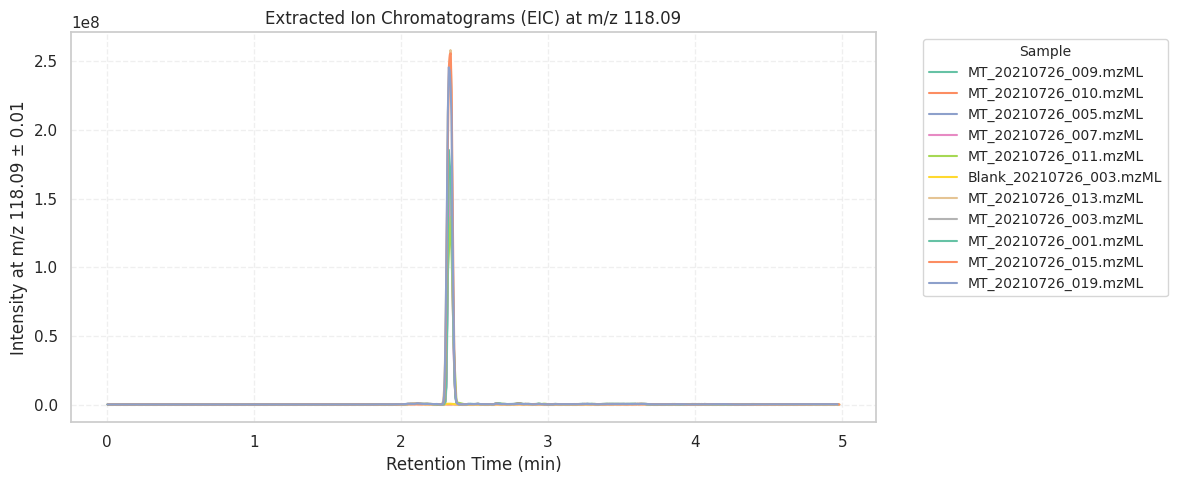

In [ ]:
# 21 - L-Valine + [M+H]+ adduct
mol_weight = 117.0789 + 1.007276
extract_and_plot_eic(file_list, mz=mol_weight, tolerance=0.01)

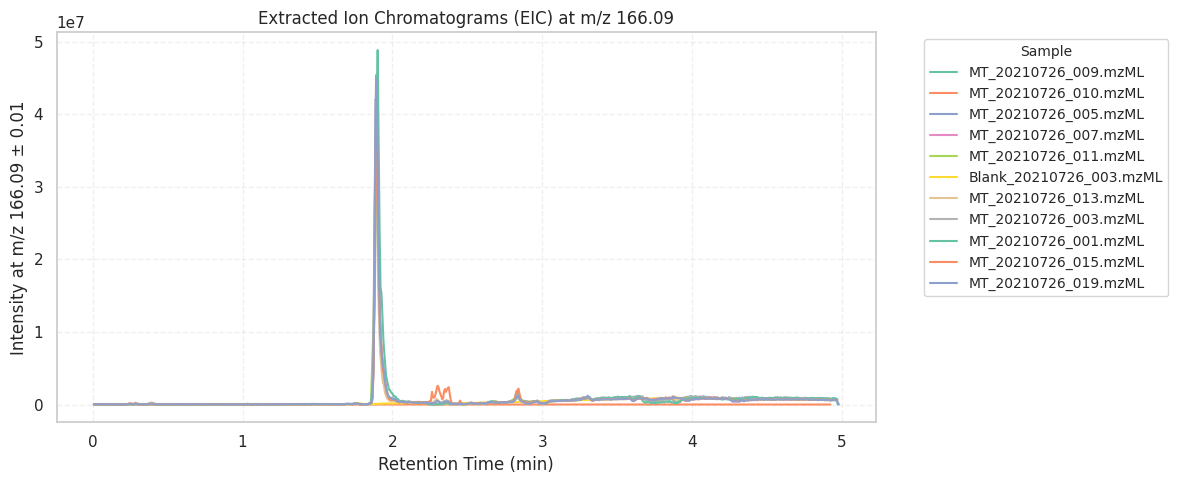

In [ ]:
# 22 - L-Phenylalanine + [M+H]+ adduct
mol_weight = 165.0790 + 1.007276
extract_and_plot_eic(file_list, mz=mol_weight, tolerance=0.01)

For L-Valine and L-Phenylalanine, we observe clean EICs with no unexpected peaks from the blank sample.

### Conclusion

Considering all quality metrics, MT__010 was consistently identified as a low-quality outlier. Although it is a Qstd, it behaves differently from the other samples and will be removed prior to downstream statistical analysis to ensure good data quality.